# Analisi Risultati

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

from dataset import instances, results
from dataset.data import *
from itertools import product

%matplotlib inline

In [2]:
T = range(48)
month = 7

instance_all = {i: dict() for i in INSTS}
result_all = {i: dict() for i in INSTS}
for i, func in product(INSTS, FUNCS):
    instance_all[i][func] = instances.load_energy_data_distances(INSTANCES['B'][48][i], month, func, 2)[1]
    result_all[i][func] = results.load_data(RESULTS_DISTANCES_ENERGY[48][i][2][func])

In [3]:
def plot_all(function=FUNCS, n_instance=INSTS, k=0, facility_power=True, battery_capacity=True, energy_produced=True, \
             energy_used=True, energy_left=True, energy_purchased=True):
    instance = instance_all[n_instance][function]
    result = result_all[n_instance][function]

    plt.figure(figsize=(8, 6))
    if facility_power: plt.plot(T, [instance['C'][0] for _ in T], color='blue', alpha=.25, label='$C_{}$'.format(k))
    if battery_capacity: plt.plot(T, [instance['G'][0] for _ in T], color='orange', alpha=.3, label='$G_{}$'.format(k))
    if energy_produced: plt.plot(T, [instance['e'][k][t] for t in T], label='$e_{}^t$'.format(k), color='green')
    if energy_used: plt.plot(T, [result[t][k]['v'] for t in T], label='$v_{}^t$'.format(k), color='blue')
    if energy_left: plt.plot(T, [result[t][k]['g'] for t in T], label='$g_{}^t$'.format(k), color='orange')
    if energy_purchased: plt.plot(T, [result[t][k]['z'] for t in T], label='$z_{}^t$'.format(k), color='red')
    plt.xticks(range(0, 48, 2), [i//2 for i in range(0, 48, 2)])
    plt.ylim(0, max(max([instance['e'][k][t] for t in T for k in K])+50000, instance['C'][0]+10000))
    plt.title('Facility {}'.format(k))
    if battery_capacity or facility_power or energy_produced or energy_used \
        or energy_left or energy_purchased: plt.legend()

_ = widgets.interact(plot_all, k=(0, 9, 1))

interactive(children=(Dropdown(description='function', options=('constant', 'linear', 'quadratic'), value='con…

## Energia persa

Nella facility $k$ l'energia persa al tempo $t$, ossia l'energia che non viene usata in $t$ e non viene immagazzinata, è

$$
\max\{(g_k^{t-1} + e_k^t + z_k^t) - (v_k^t + g_k^t), 0\}
$$

quindi l'energia persa complessivamente è data da

$$
\lambda := \sum_{t \in T} \sum_{k \in K} \max\{(g_k^{t-1} + e_k^t + z_k^t) - (v_k^t + g_k^t), 0\}
$$

e la parcentuale di energia persa rispetto al totale prodotto:

$$
\delta := \frac{\lambda \cdot 100}{\sum_{t \in T} \sum_{k \in K} e_k^t} \%
$$

In [4]:
δ_all = {func: list() for func in FUNCS}

for inst, func in product(INSTS, FUNCS):
    _, instance = instances.load_energy_data_distances(INSTANCES['B'][48][inst], 7, func, 2)
    res = results.load_data(RESULTS_DISTANCES_ENERGY[48][inst][2][func])
    
    λ = sum([max((res[max(t-1, 0)][k]['g'] + instance['e'][k][t] + res[t][k]['z']) \
                 - (res[t][k]['v'] + res[t][k]['g']), 0) for t in T for k in K])
    e_tot = sum([instance['e'][k][t] for t in T for k in K])
    δ = (λ * 100) / e_tot

    δ_all[func].append(round(δ, 2))

In [5]:
δ_all

{'constant': [49.85, 49.88, 49.88, 49.84, 49.84],
 'linear': [64.38, 64.42, 64.42, 64.39, 64.39],
 'quadratic': [72.69, 72.69, 72.71, 72.7, 72.7]}

In [6]:
δ_avg = [sum(δ_all[func]) / len(INSTS) for func in FUNCS]

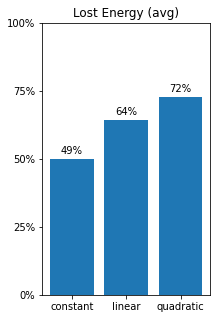

In [7]:
plt.figure(figsize=(3, 5))
plt.bar(FUNCS, δ_avg, width=.8)
for i, func in enumerate(FUNCS): plt.text(i-.2, δ_avg[i]+2, '{}%'.format(int(δ_avg[i])))
plt.yticks(range(0, 110, 25), ['{}%'.format(y) for y in range(0, 110, 25)])
plt.title('Lost Energy (avg)')
plt.show()